This line is required to run Tensorflow Object Detection API on Windows

Set PYTHONPATH to two modules within the API to prevent any import errors

In [1]:
!set PYTHONPATH=D:\SharedLinux_D\CPSC_597\OCR_Math_Expressions\models\research;D:\SharedLinux_D\CPSC_597\OCR_Math_Expressions\models\research\slim

### Imports

In [2]:
# call this before import maptlotlib ad after too
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
# import six.moves.urllib as urllib
import sys
# import tarfile
import tensorflow as tf
import zipfile
import cv2
import time
# from distutils.version import StrictVersion
# from collections import defaultdict
# from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import glob
import pandas as pd
import keras
from keras.models import load_model
from keras import backend as K
import xml.etree.ElementTree as ET
from utils import one_hot_encode_to_char_list, read_annotation, get_iou, calculate_map
K.set_image_data_format('channels_first')
%matplotlib inline

Using TensorFlow backend.


In [3]:
# turn off tensorflow INFO (Debugging info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
OD_PATH = 'models/research/object_detection/'

# append object_detection dir
sys.path.append(OD_PATH+"..")
from object_detection.utils import ops as utils_ops
# od imports
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Helpers

In [5]:
# Object Detection Helpers
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

### Load Faster-RCNN model

In [6]:
# VARIABLES
MODEL_NAME = 'faster_rcnn_resnet50_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = OD_PATH +'faster_rcnn_resnet50_training/'+ MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = OD_PATH + "faster_rcnn_resnet50_training/data/object-detection.pbtxt"

In [7]:
# Load tf model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Load Object Detection label

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Load images

In [9]:
PATH_TO_TEST_IMAGES_DIR = "datasets/object_detection/test/*.png"
TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR))
print("Test Image paths: ")
for i in TEST_IMAGE_PATHS:
    print(i)
    
# Change TEST/TRAIN Images to test here
image_paths = TEST_IMAGE_PATHS

Test Image paths: 
datasets/object_detection/test\exp0015.png
datasets/object_detection/test\exp0016.png
datasets/object_detection/test\exp0029.png
datasets/object_detection/test\exp0037.png
datasets/object_detection/test\exp0044.png
datasets/object_detection/test\exp0051.png
datasets/object_detection/test\exp9.png


### Load CNN/ANN Model

In [10]:
IMAGE_SIZE = (320, 320)
models_path = "trained_models/"

# CNN
cnn = load_model(models_path+"model3.h5")

# ANN
#ann = load_model(models_path+"ann1.h5")

### Load symbols

In [11]:
symbols = pd.read_csv("processed_data/symbols.csv").drop(["Unnamed: 0"], axis=1)
symbols.head()

,latex,old_symbol,new_id
0,A,31,0
1,B,32,1
2,C,33,2
3,D,34,3
4,E,35,4


### Object Detection

In [12]:
%matplotlib inline

In [13]:
image_paths = [TEST_IMAGE_PATHS[1]]

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp0016.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4592886  xmin:  0.80772877  ymax:  0.58294106  xmax  0.8950295
left:  258.47320556640625  right:  286.4094352722168  top:  146.97235107421875  bottom  186.5411376953125
Top left point: ( 258 ,  146 ) and Bottom right point: ( 286 ,  186 )
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 65.06 %
Symbol_id: 24 , Latex: Y , Confidence Score: 12.61 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.84 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.63 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.46 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 2.49 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.46 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.29 %


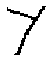

***************
Box: 
ymin:  0.4637743  xmin:  0.050667226  ymax:  0.58251876  xmax  0.17326547
left:  16.213512420654297  right:  55.44495105743408  top:  148.40777397155762  bottom  186.40600204467773
Top left point: ( 16 ,  148 ) and Bottom right point: ( 55 ,  186 )
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 93.33 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.22 %


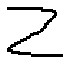

***************
Box: 
ymin:  0.4696555  xmin:  0.21608396  ymax:  0.5887567  xmax  0.3260028
left:  69.14686679840088  right:  104.32089805603027  top:  150.28976440429688  bottom  188.40213775634766
Top left point: ( 69 ,  150 ) and Bottom right point: ( 104 ,  188 )
CNN/ANN Predictions:
Symbol_id: 83 , Latex: - , Confidence Score: 48.59 %
Symbol_id: 104 , Latex: = , Confidence Score: 22.36 %
Symbol_id: 94 , Latex: \div , Confidence Score: 14.23 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 7.81 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 4.4 %


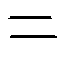

***************
Box: 
ymin:  0.46143577  xmin:  0.58968365  ymax:  0.5513729  xmax  0.7266938
left:  188.69876861572266  right:  232.54201889038086  top:  147.65944480895996  bottom  176.43932342529297
Top left point: ( 188 ,  147 ) and Bottom right point: ( 232 ,  176 )
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 31.84 %
Symbol_id: 19 , Latex: T , Confidence Score: 22.73 %
Symbol_id: 84 , Latex: + , Confidence Score: 16.82 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 16.27 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.13 %
Symbol_id: 5 , Latex: F , Confidence Score: 2.52 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.46 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.32 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.02 %


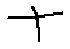

***************
Box: 
ymin:  0.46859694  xmin:  0.39668804  ymax:  0.5685658  xmax  0.5022097
left:  126.9401741027832  right:  160.70711135864258  top:  149.95101928710938  bottom  181.9410514831543
Top left point: ( 126 ,  149 ) and Bottom right point: ( 160 ,  181 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.85 %


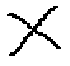

true {'x1': 14, 'x2': 62, 'y1': 148, 'y2': 186}
pred {'x1': 16.213512420654297, 'x2': 55.44495105743408, 'y1': 148.40777397155762, 'y2': 186.40600204467773}
IOU : 0.8015515135072201
---------------
true {'x1': 126, 'x2': 161, 'y1': 148, 'y2': 182}
pred {'x1': 126.9401741027832, 'x2': 160.70711135864258, 'y1': 149.95101928710938, 'y2': 181.9410514831543}
IOU : 0.9077356386359413
---------------
true {'x1': 188, 'x2': 235, 'y1': 144, 'y2': 178}
pred {'x1': 188.69876861572266, 'x2': 232.54201889038086, 'y1': 147.65944480895996, 'y2': 176.43932342529297}
IOU : 0.7896141558511715
---------------
true {'x1': 251, 'x2': 288, 'y1': 144, 'y2': 184}
pred {'x1': 258.47320556640625, 'x2': 286.4094352722168, 'y1': 146.97235107421875, 'y2': 186.5411376953125}
IOU : 0.6669372690962341
---------------
true {'x1': 70, 'x2': 103, 'y1': 148, 'y2': 184}
pred {'x1': 69.14686679840088, 'x2': 104.32089805603027, 'y1': 150.28976440429688, 'y2': 188.40213775634766}
IOU : 0.785548866803322
---------------
{'TP'

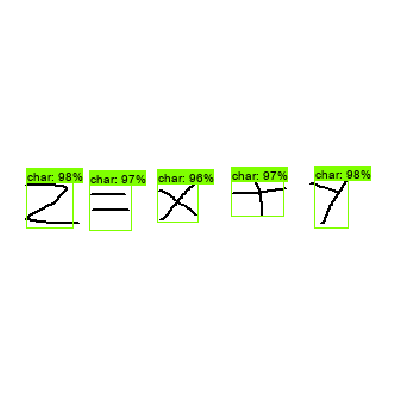

Mean Average Precision (mAP):  1.0
Mean IOU:  0.7902774887787778


In [14]:
cnf = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
map_data = []
iou_data = []

for image_path in image_paths:
    image_path = image_path.replace("\\", "/")
    im_name = image_path.split("/")[-1]
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.asarray(image)
    if len(image_np.shape) < 3:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    else:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)
    print('-'*25)
    print('Detecting Boxes for Image: ', image_path)
    
    print('Image shape: ', image_np.shape)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # crop image and display
    im_width, im_height = image.size
    cropped_images = []
    boxes_pred = []
    for i in range(output_dict['num_detections']):
        if output_dict['detection_scores'][i] > 0.8:
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.array([output_dict['detection_boxes'][i]]),
                np.array([output_dict['detection_classes'][i]]),
                np.array([output_dict['detection_scores'][i]]),
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=1)
            (ymin, xmin, ymax, xmax) = output_dict['detection_boxes'][i]
            (left, right, top, bottom) = (xmin * im_width,
                                          xmax * im_width,
                                          ymin * im_height,
                                          ymax * im_height)
            print('*'*15)
            print("Box: ")
            print("ymin: ", ymin," xmin: ", xmin, " ymax: ", ymax," xmax ", xmax)
            print("left: ", left," right: ", right," top: ", top," bottom ", bottom)
            print("Top left point: (",int(left),", ",int(top),") and Bottom right point: (",int(right),", ",int(bottom),")")
            
            cropped_image = image.crop((left, top, right, bottom))
            
            
            # boxes_pred.append([left, right, top, bottom])
            boxes_pred.append({
                'x1':left,
                'x2':right,
                'y1':top,
                'y2':bottom
            })
            
            # Predict label for cropped image with CNN
            c_im = np.asarray(cropped_image)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_BGRA2RGBA)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2RGB)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2GRAY)
            c_im = cv2.resize(c_im, (32,32))
            c_im = c_im / 255.0
            # Symbol Prediction
            # CNN
            c_im = np.resize(c_im, (1, 1, 32, 32))
            res = cnn.predict(c_im)
            # ANN
            # c_im = c_im.flatten().reshape((1, 32*32))
            # print(c_im.shape)
            # res = ann.predict(c_im)
            #
            res = res.flatten()
            lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
            print("CNN/ANN Predictions:")
            for j in lbls:
                symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
                latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
                print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', round(j[1]*100, 2), '%')
            plt.figure(figsize=(1,1))
            plt.axis('off')
            temp_ = np.asarray(cropped_image)
            plt.imshow(temp_)
            plt.show()
            cropped_images.append(np.asarray(cropped_image))
            # cv2.imshow('model', np.asarray(cropped_image))
    # calculate IOU
    xml_path = image_path[:-3]+'xml'
    xml_path = xml_path.replace("\\", "/")
    boxes_true = read_annotation(xml_path)

    ious = []
    iou_threshold = 0.5
    # dont reset cnf
    cnf = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
    for t in boxes_true:
        box_present = False
        for p in boxes_pred:
            if p['x1'] <= t['x1'] + 10 and p['x1'] >= t['x1'] - 10:
                print('true', t)
                print('pred', p)
                iou = get_iou(t, p)
                iou_data.append(iou)
                ious.append(iou)
                print('IOU :', iou)
                print('-----'*3)
                box_present = True
                if iou > iou_threshold:
                    cnf['TP'] += 1
                else:
                    cnf['FP'] += 1
                break
        if not box_present:
            cnf['FN'] += 1
    print(cnf)
    
    # prevent division by 0 error
    if cnf['TP'] + cnf['FP'] != 0 and cnf['TP'] + cnf['FN'] != 0:
        precision = cnf['TP'] / (cnf['TP'] + cnf['FP'])
        print('Precision: ', precision)
        recall = cnf['TP']/ (cnf['TP'] + cnf['FN'])
        print('Recall: ', recall)
        map_data.append((precision, recall))
    #

    plt.figure(figsize=(7,7))
    plt.axis('off')
    temp_ = cv2.resize(image_np, (int(im_width), int(im_height)))
    plt.imshow(temp_)
    plt.show()

# Calculate mAP (Mean Average Precision Score)
# mean_ap = calculate_map(map_data)
# print("Mean Average Precision (mAP): ", mean_ap)
print("Mean Average Precision (mAP): ", np.mean([i[0] for i in map_data]))

# Mean IOUs (not an ideal metric)
print("Mean IOU: ", np.mean(iou_data))